<a href="https://colab.research.google.com/github/gvigkannan/DL_Frameworks/blob/PyTorch/hw_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on "Transfer Learning for Computer Vision Tutorial" from PyTorch
Adapted by Vignesh Kannan

## All Libraries


In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd 
import time
import os 
import copy
import matplotlib.pyplot as plt
import urllib.request

### Importing Torch Libraries


In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

## Dataset Related


### Practice Dataset

In [4]:
# train_data = torchvision.datasets.CIFAR1

In [5]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip /content/hymenoptera_data.zip

--2021-03-31 05:10:42--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.93.5, 13.225.93.46, 13.225.93.34, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.93.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  80.4MB/s    in 0.6s    

2021-03-31 05:10:44 (80.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  /content/hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_

In [6]:
## Loading and Transforming the data
## Data Augmentation + Normalization 
## Just Normalization for Validation

data_transforms = {
    "train": transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224), ## ImageNet Versions
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])

    ]), 
}

## Need to find a robust way to calculate the normalization values

In [9]:
data_dir = "/content/hymenoptera_data"
img_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                     data_transforms[x]) for x in ['train', 'val']}

## Creating Data Loaders:
dataset_loader = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size = 32, 
                                          shuffle = True, num_workers = 2)  for x in ['train', 'val']}

data_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}
class_names = img_datasets['train'].classes

## Loading Torch to GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
                

Device:  cuda:0


In [10]:
## Visualizing some of the images of the dataset
def imshow(dataset, title = None):
    """
    Show a sample grid of input images.
    params: DataLoader output
    returns: None
    """

    ## To rectify for the channel variation between PyTorch and Matplotlib
    inp = dataset.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (10, 10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


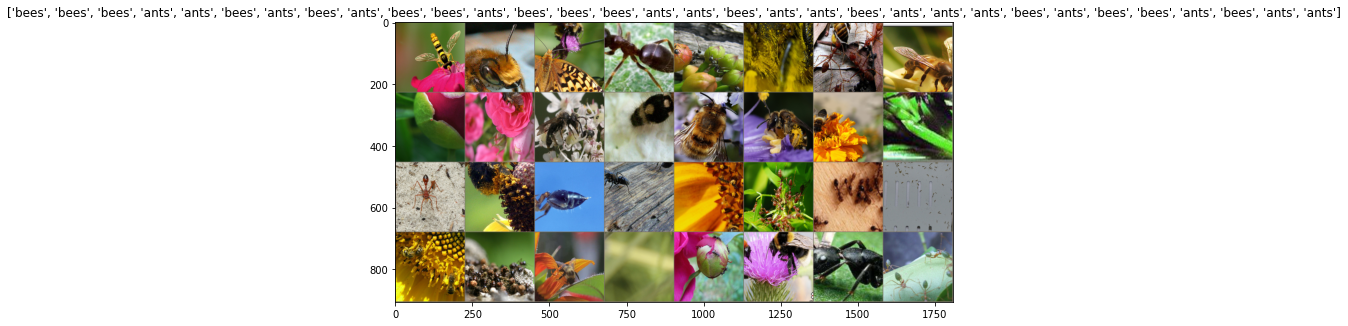

In [12]:
## Visualize Input Image Grid
inputs, classes = next(iter(dataset_loader['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

## Model Loading and Training


### Model Methods


In [46]:
## Function to train models
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    """
    Function to train a given model 
    params: model: Torch Model
    params: criterion: training criterion
    params: optimizer: Optimizer used for training
    params: scheduler: Learning Rate Scheduler
    params: num_epochs: Training Epochs

    returns: model: Trained Model
    """
    start_time = time.time()

    best_WandB = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    ## For all the epochs:
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("=" * 10)

        ## To set different models to the model
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_pred = 0

            ## Iterating over the dataset
            for imgs, labels in dataset_loader[phase]:
                imgs = imgs.to(device)
                labels = labels.to(device)

                ## Reset gradient updates
                optimizer.zero_grad()

                ## Forward Prop
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(imgs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    ## Backward Prop + Optimizer

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                ## Statistics
                running_loss += loss.item() + imgs.size(0)
                running_pred += torch.sum(preds == labels.data)

            ## Learning Rate Scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_pred.double() / data_sizes[phase]

            print("{} Loss: {:.4f} \tAcc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            
            ## Deep Copy Model:
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc 
                best_WandB = copy.deepcopy(model.state_dict())
                print("New Best Acc, Weights Updated")

            ## Loading the Best Model Weights
            model.load_state_dict(best_WandB)
    end_time = time.time() - start_time
    print("Total Training Time: {:.0f}m {:.0f}s".format(end_time //60, end_time % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    print()
    return model





In [47]:
## Visualizing the Model Predictions
def visualize_modelPred(model, num_imgs = 6):
    training_hist = model.training
    model.eval()
    imgs_loaded = 0
    fig = plt.figure(figsize = (10, 10))

    ## Not considering gradients
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataset_loader['val']):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for j in range(imgs.size()[0]):
                imgs_loaded += 1
                ax = plt.subplot(num_imgs // 2, 2, imgs_loaded)
                ax.axis('off')

                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                
                ## Why CPU?
                imshow(imgs.cpu().data[j])
                
                if imgs_loaded == num_imgs:
                    model.train(mode = training_hist)
                    return model.train(mode = training_hist)


### Model Loading


In [48]:
model_ft = models.vgg16(pretrained = True)

## Getting the output of the VGG16 Layers!
num_features = 25088 ## Data from model output
## Custom Layer:
model_ft.classifier = nn.Linear(num_features, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

## Optimizer:
optimizer_fn = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

## Decay LR:
exp_scheduler = lr_scheduler.StepLR(optimizer_fn, step_size = 7, gamma = 0.1)

In [25]:
# model_resnet = models.resnet18(pretrained=True)
# model_vgg = models.vgg16(pretrained = True)
#model_vgg

### Model training and Evaluation

In [49]:
model_ft = train_model(model_ft, criterion, optimizer_fn, exp_scheduler, num_epochs = 25)
## Training on CPU for one epoch: ~7m
## Training on GPU for one epoch: 2s
## Model Doesn't Learn!
## Most Likely Problem in the train_model function

Epoch 1/25
train Loss: 1.0185 	Acc: 0.7131
val Loss: 1.0311 	Acc: 0.4510
New Best Acc, Weights Updated
Epoch 2/25
train Loss: 1.0157 	Acc: 0.7869
val Loss: 1.0314 	Acc: 0.4510
Epoch 3/25
train Loss: 1.0171 	Acc: 0.7787
val Loss: 1.0310 	Acc: 0.4510
Epoch 4/25
train Loss: 1.0124 	Acc: 0.8115
val Loss: 1.0311 	Acc: 0.4510
Epoch 5/25
train Loss: 1.0108 	Acc: 0.8156
val Loss: 1.0312 	Acc: 0.4510
Epoch 6/25
train Loss: 1.0104 	Acc: 0.8238
val Loss: 1.0311 	Acc: 0.4510
Epoch 7/25
train Loss: 1.0099 	Acc: 0.8279
val Loss: 1.0310 	Acc: 0.4510
Epoch 8/25
train Loss: 1.0200 	Acc: 0.6393
val Loss: 1.0311 	Acc: 0.4510
Epoch 9/25
train Loss: 1.0185 	Acc: 0.6680
val Loss: 1.0311 	Acc: 0.4510
Epoch 10/25
train Loss: 1.0165 	Acc: 0.7418
val Loss: 1.0313 	Acc: 0.4510
Epoch 11/25
train Loss: 1.0174 	Acc: 0.6967
val Loss: 1.0310 	Acc: 0.4510
Epoch 12/25
train Loss: 1.0175 	Acc: 0.6598
val Loss: 1.0311 	Acc: 0.4510
Epoch 13/25
train Loss: 1.0183 	Acc: 0.6680
val Loss: 1.0312 	Acc: 0.4510
Epoch 14/25
train